# 09 - Statistical Inference 

by [Alejandro Correa Bahnsen](http://www.albahnsen.com/) & [Iván Torroledo](http://www.ivantorroledo.com/)

version 1.2, Feb 2018

## Part of the class [Machine Learning for Risk Management](https://github.com/albahnsen/ML_RiskManagement)



This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US).

## How we do Statiscal Inference in Machine Learning?

It's usually acepted that Machine Learning algorithms have a huge power to predict and describe unknown data based on observed data. However, Machine Learning algorithms is not generally concern about the statistical inference for example as significance of predictions or estimated parameters. This focus it's usually true for traditional quantitative areas like econometrics, psicometrics that use significance as a evaluation metrics of models.

The following data is a sample of demographic and bank information of certain group of clients.

In [2]:
import pandas as pd
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Credit.csv', index_col=0)
data.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279
10,71.061,6819,491,3,41,19,Female,Yes,Yes,African American,1350


Usually, this kind of data it's commonly used to create scoring models. With the tools already studied, we could achieve this task easily. However this time, we would like to know which variables are important to explain Balance account of a given client?. In other words, we would like to know if it is a statistical relation between Balance and the other variables. For now, take Gender to test this hypothesis.  


**Question:**
Is Gender **statistically** relevant to explain Balance account of a client? 
To answer this question we could find if there are a difference in Balance account between Males and Females.

But, first analyze data visually to get a sense of data:

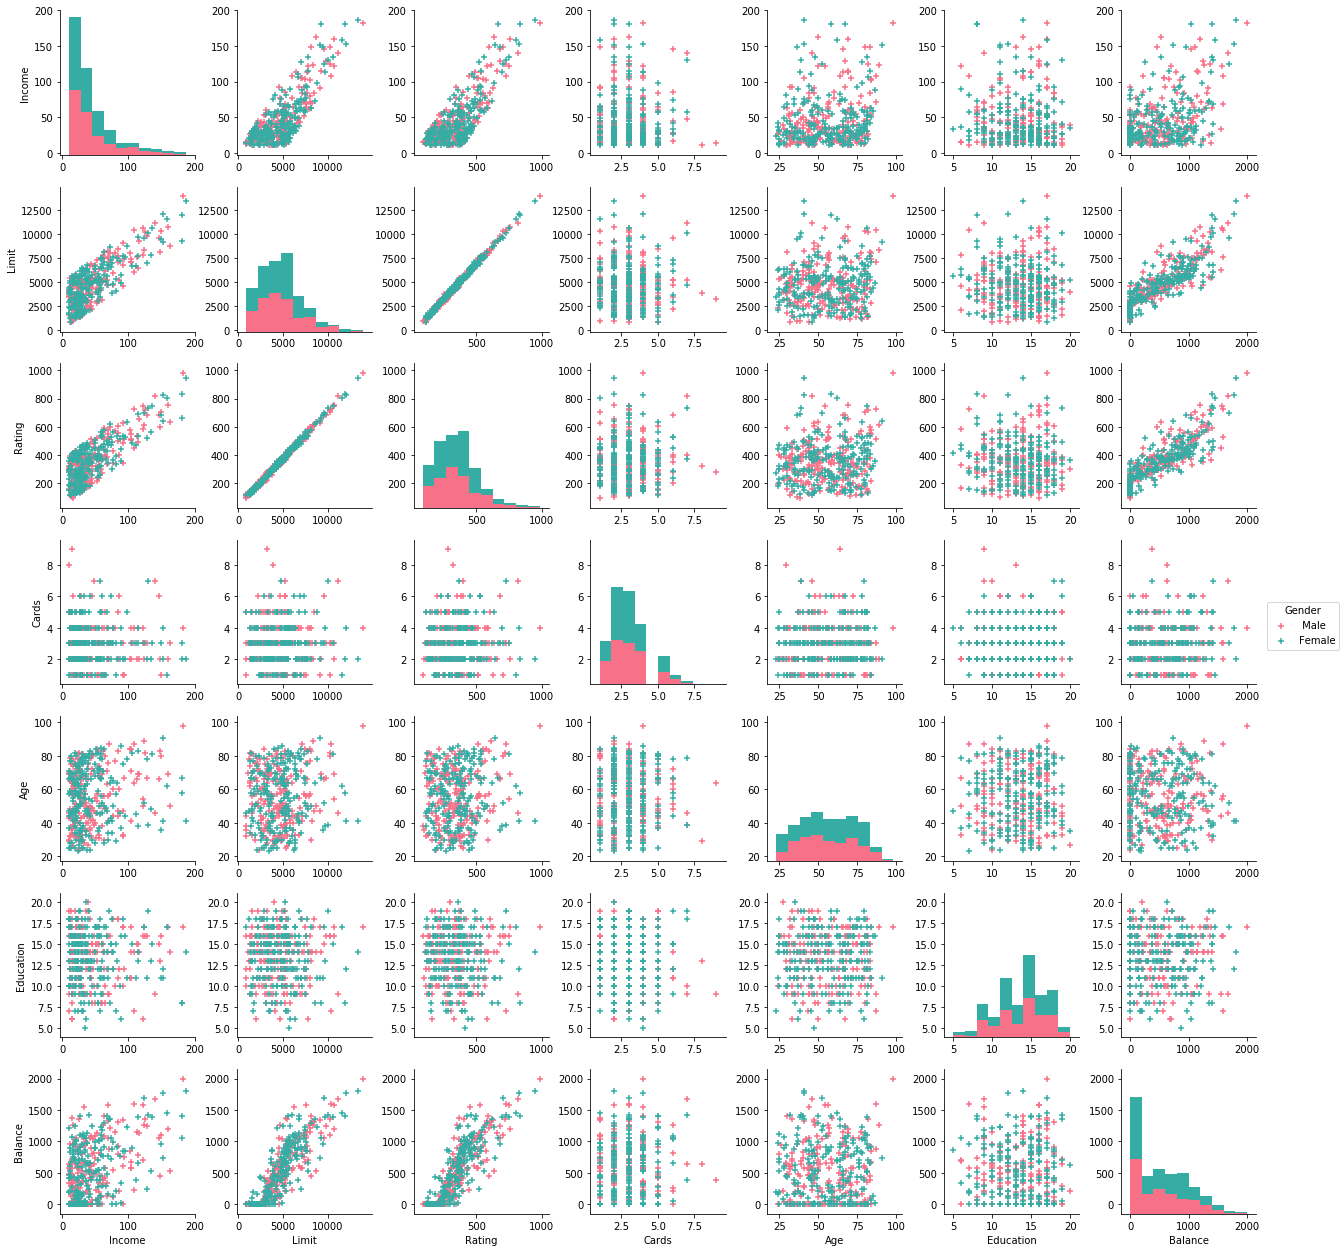

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.pairplot(data,hue='Gender',palette="husl",markers="+")

It seems that Balance account distribution doesn't change across Gender. But, if we calculate the mean value of the Balance by Male and Female?

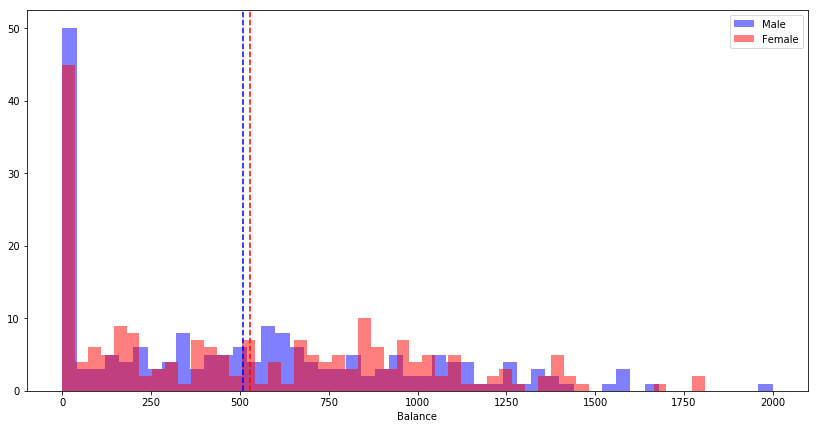

In [3]:

# splitting data  
male_= data[data.Gender==' Male'].Balance
female_ = data[data.Gender=='Female'].Balance

fig = plt.figure(figsize=(14,7))
n, bins, patches = plt.hist(male_, bins =50, facecolor='blue', alpha=0.5,label='Male')
n, bins, patches = plt.hist(female_, bins =50,facecolor='red', alpha=0.5,label='Female')
plt.axvline(male_.mean(),linestyle='--',color='blue',)
plt.axvline(female_.mean(),linestyle='--',color='red',)
plt.xlabel('Balance')
plt.legend();

In [4]:
Gender_differences = data.groupby('Gender').mean()
Gender_differences

,Income,Limit,Rating,Cards,Age,Education,Balance
Gender,,,,,,,
Male,45.610316,4713.165803,353.518135,2.989637,55.595855,13.466321,509.803109
Female,44.853928,4756.516908,356.265700,2.927536,55.734300,13.434783,529.536232


In [5]:
print('The mean difference in Balance by Gender is : '+ str(Gender_differences.loc[' Male','Balance']-Gender_differences.loc['Female','Balance']))

The mean difference in Balance by Gender is : -19.73312307576782


So, we got it?, is this difference between Male and Female Balance enough to answer the initial question?

**Short Answer:** No!

**Long Answer:** No, we calculate a mean difference, but we haven't checked yet whether this value is statistically significant

## Hypothesis Testing

To check the statistical significance of the mean difference estimated above we can postulate the following hypothesis:

    Ho: There is no difference in Balance account between Male and Female 
    
    Ha: There is a statistical difference in Balance account between Male and Female
    
We want to calculate the p-value of our estimation to compare with a accepted threshold of significance choosen by us:

$\alpha = (1\%,5\%,10\%)$ 

### How we calculate the P-value?

1. We can use the traditional method of statistics: assume a distribution for the data, calculate a statistcs like t distribution. 

2. Using the data and some sampling techniques we can computing the empirical distrubutin of data, and to check what is the probability asocieated with our estimation (P-value). 


As we know traditional method (1), lets do the uncommon approach. We are going to see that this method can be implemented easily and have a huge power in more complicated tasks.


### Data Sampling: Shuffling Algorithm 

The Shuffling algorithm is a sampling technique commonly used to simulate empirical distributions from the data.

The basic idea is to simulate the distribution by shuffling the labels (Male and Female) repeatedly and computing a desired statistic. In our case, the choosen statistic is the mean difference.

If the labels (Male and Female) really don't matter to explain Balance, then switching them randomly sould not change the result we got. 

**Steps:**

1. Shuffle labels in the data. 
2. Rearrange 
3. Compunte the statistics: mean by Gender.

In [6]:
# Building features and target variable
X = data.Gender.map({' Male': 1, 'Female':0})
Y = data.Balance

First calculate the statistics (mean difference) in the data. 

In [7]:
original_difference = female_.mean() - male_.mean()
print('The difference in Balance by Gender (in the data) is: '+ str(original_difference))

The difference in Balance by Gender (in the data) is: 19.73312307576782


In [8]:
# Create a Data Frame with desiered variables 
dataframe = pd.DataFrame(X)
dataframe['Balance'] = Y
dataframe.head()

,Gender,Balance
1,1,333
2,0,903
3,1,580
4,0,964
5,1,331


In [9]:
# Step 1 & 2 
def shuffle_data(frame):
    vec = np.zeros(frame.Gender.count())#.astype(float)
    vec[np.random.choice(frame.Gender.count(),int(sum(frame.Gender)),replace=False)] = 1
    frame['Gender'] = vec 
    return frame
# Step 3
def mean_difference(frame):
    return frame.groupby('Gender').mean().loc[0,'Balance'] - frame.groupby('Gender').mean().loc[1,'Balance']

In [10]:
import numpy as np

def simulate_distribution(frame, N=100):
    a = []
    for i in range(N):
        a.append(mean_difference(shuffle_data(dataframe)))
    return a

def plot_distribution(dist,data,color='blue',bins=bins,orig=True):
    fig = plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(dist, bins = bins, normed=1.0, facecolor=color, alpha=0.5)
    values, base = np.histogram(dist, bins = bins)
    if orig:
        plt.axvline(np.mean(data), color=color, linestyle='dashed', linewidth=2,label='Original data')
        plt.legend()
    plt.title('Mean difference')

In [11]:
## Simulation
N = 1000
distribution = simulate_distribution(dataframe,N)

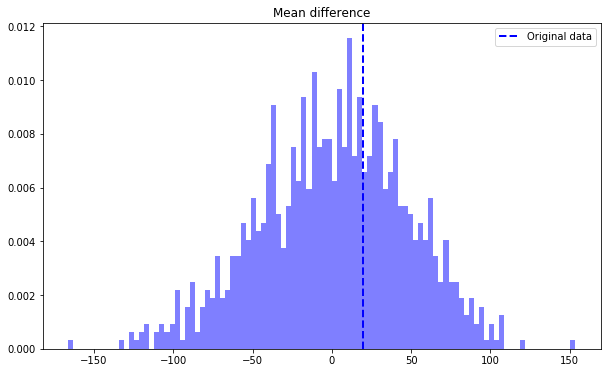

In [12]:
plot_distribution(distribution,original_difference,'blue',100)

In [13]:
# Calculating P-Value
def pvalue(dist,estimation):
    return float(sum(np.array(dist)>estimation))/len(dist)

In [14]:
p_value = pvalue(distribution,original_difference)
p_value

0.355

### Conclusion

As we get the calculated P-value for the mean difference of our data is 0.316, so for any of the proposed significance thresholds we cann't reject the null hypothesis. So there is not statistical evidence to show that balance account is different between Male and Female. 